In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [3]:
tweets_data = pd.read_csv('/content/stock_tweets.csv')
print(tweets_data.shape)
tweets_data.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
stock_name = 'AAPL' # Apple company
data = tweets_data[tweets_data['Stock Name'] == stock_name]
print(data.shape)
data.head()

(5056, 4)


,Date,Tweet,Stock Name,Company Name
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.


In [6]:
sent_df = data.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,,,,
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,,,,
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,,,,
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,,,,
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,,,,


In [7]:
%%time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# Download VADER lexicon
nltk.download('vader_lexicon')

sentiment_analyzer = SentimentIntensityAnalyzer()
for idx, row in sent_df.iterrows():
    try:
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[idx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[idx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[idx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[idx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[idx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print(sent_df.loc[idx, 'Tweet'])  # Fixed indexx to idx
        print(idx)
        break

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


CPU times: user 2.19 s, sys: 5.61 ms, total: 2.2 s
Wall time: 2.38 s


In [8]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,0.25,0.158,0.684,0.158
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,0.3612,0.0,0.915,0.085
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,0.0,0.0,1.0,0.0
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,-0.25,0.182,0.699,0.119
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,-0.6523,0.143,0.857,0.0


In [9]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])
sent_df.head()

,Date,Tweet,sentiment_score
55958,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.25
55959,2022-09-29,After trading for 9+ years \n\nThis is how to ...,0.3612
55960,2022-09-29,Not something you see very often. \n-2 ATR mo...,0.0
55961,2022-09-29,$AAPL was down almost 5% today. Rare to see it...,-0.25
55962,2022-09-29,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,-0.6523


In [10]:
non_numeric_values = sent_df[pd.to_numeric(sent_df['sentiment_score'], errors='coerce').isna()]['sentiment_score'].unique()
sent_df['sentiment_score'] = pd.to_numeric(sent_df['sentiment_score'], errors='coerce')

twitter_df_with_date = sent_df[['Date', 'sentiment_score']].groupby('Date').mean().reset_index()

twitter_df = sent_df[['Date', 'sentiment_score']].groupby('Date').mean()
print("Shape of twitter_df with Date as index:", twitter_df.shape)
display(twitter_df.head())

Shape of twitter_df with Date as index: (365, 1)


,sentiment_score
Date,
2021-09-30,0.098900
2021-10-01,0.291891
2021-10-02,0.007525
2021-10-03,0.834400
2021-10-04,0.047410


In [11]:
all_stocks = pd.read_csv('/content/stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [12]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [13]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [14]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
1764,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,0.098900
1765,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,0.291891
1766,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,0.047410
1767,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,0.139060
1768,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,0.190330


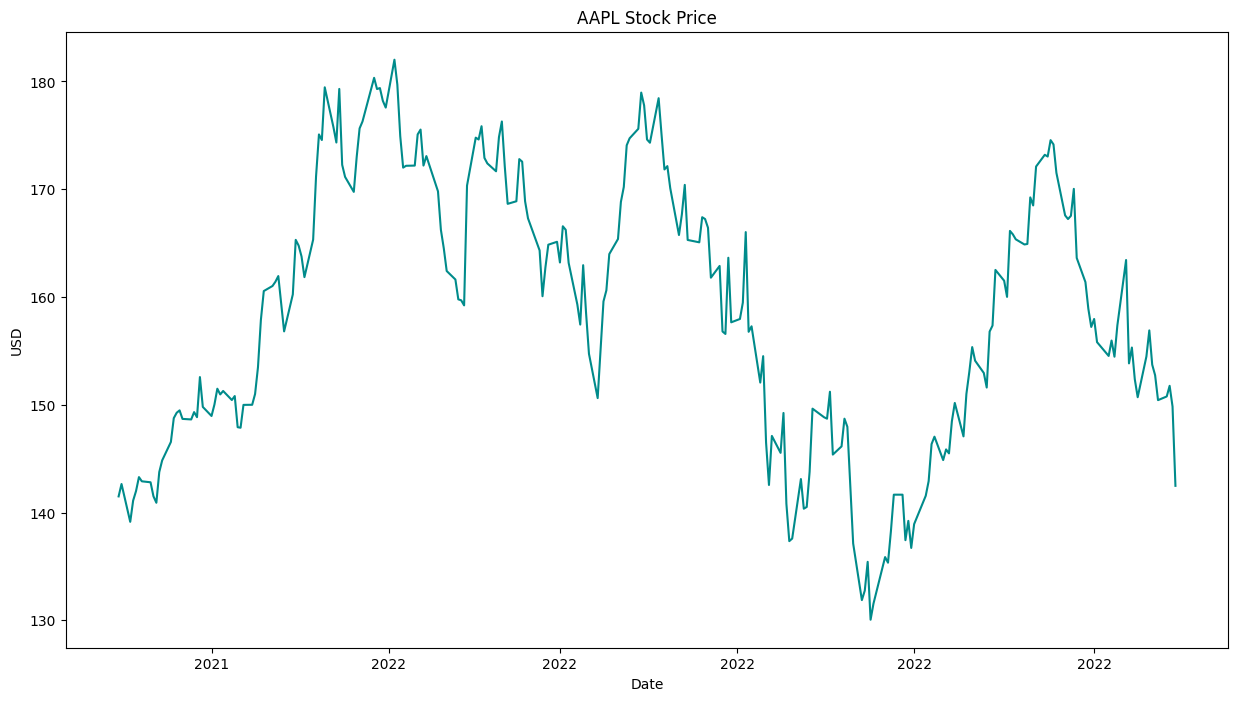

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

# **Adding technical indicators**

In [16]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [17]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,149.820007,153.169998,149.720001,152.570007,151.468567,100077900,0.025634,149.544288,145.351999,-0.728923,3.815009,152.982017,137.721981,151.359926,5.021048
1,2021-10-29,147.220001,149.940002,146.410004,149.800003,148.718567,124953200,0.205803,149.621432,145.709499,-0.413809,3.882887,153.475272,137.943726,150.319977,5.002603
2,2021-11-01,148.990005,149.699997,147.800003,148.960007,147.884644,74588300,0.250989,149.547147,146.200500,-0.481039,3.620448,153.441395,138.959604,149.413330,4.996942
3,2021-11-02,148.660004,151.570007,148.649994,150.020004,148.936981,69122000,0.237369,149.737148,146.646000,-0.385045,3.507520,153.661040,139.630960,149.817780,5.004081
4,2021-11-03,150.389999,151.970001,149.820007,151.490005,150.396362,54511500,0.036300,150.144291,147.120500,-0.429116,3.487778,154.096056,140.144945,150.932597,5.013897


In [18]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

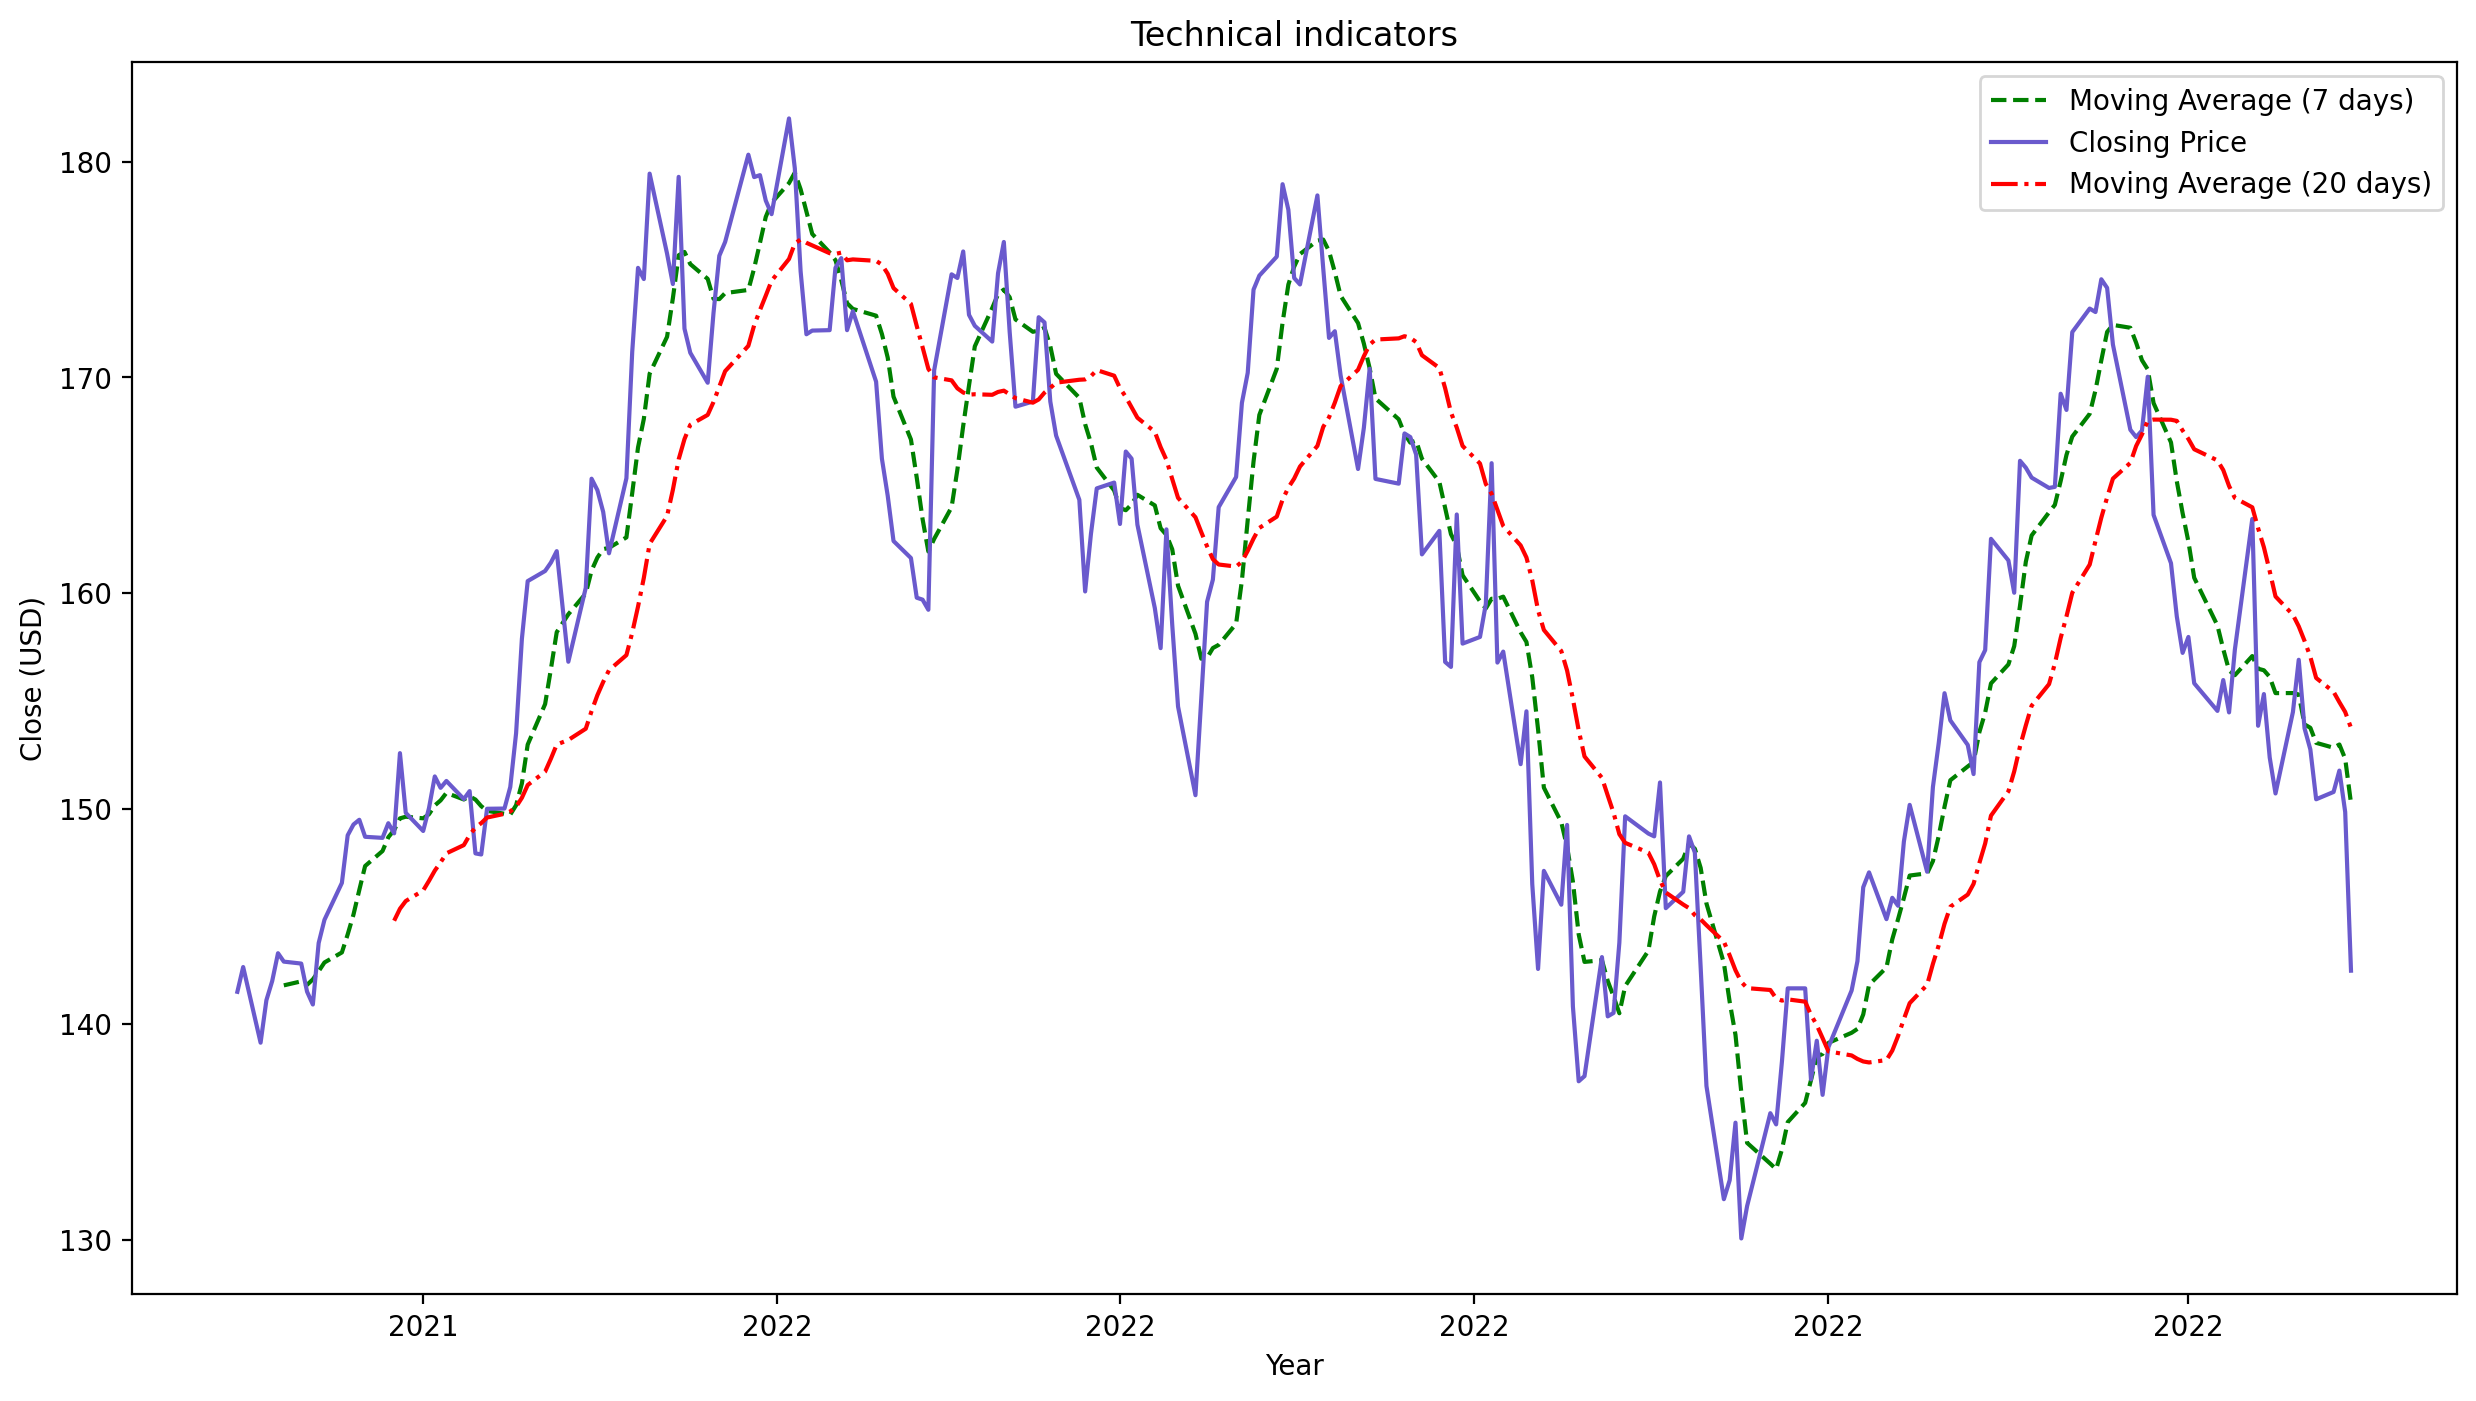

In [19]:
tech_ind(tech_df)

In [20]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [21]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [22]:
def normalize_data(df, range, target_column):

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [23]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [24]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [25]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [26]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [27]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

# **Build GAN model**

In [28]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [29]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [30]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [31]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [32]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [33]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [34]:
@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [35]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [36]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam( learning_rate)
d_optimizer = tf.keras.optimizers.Adam( learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

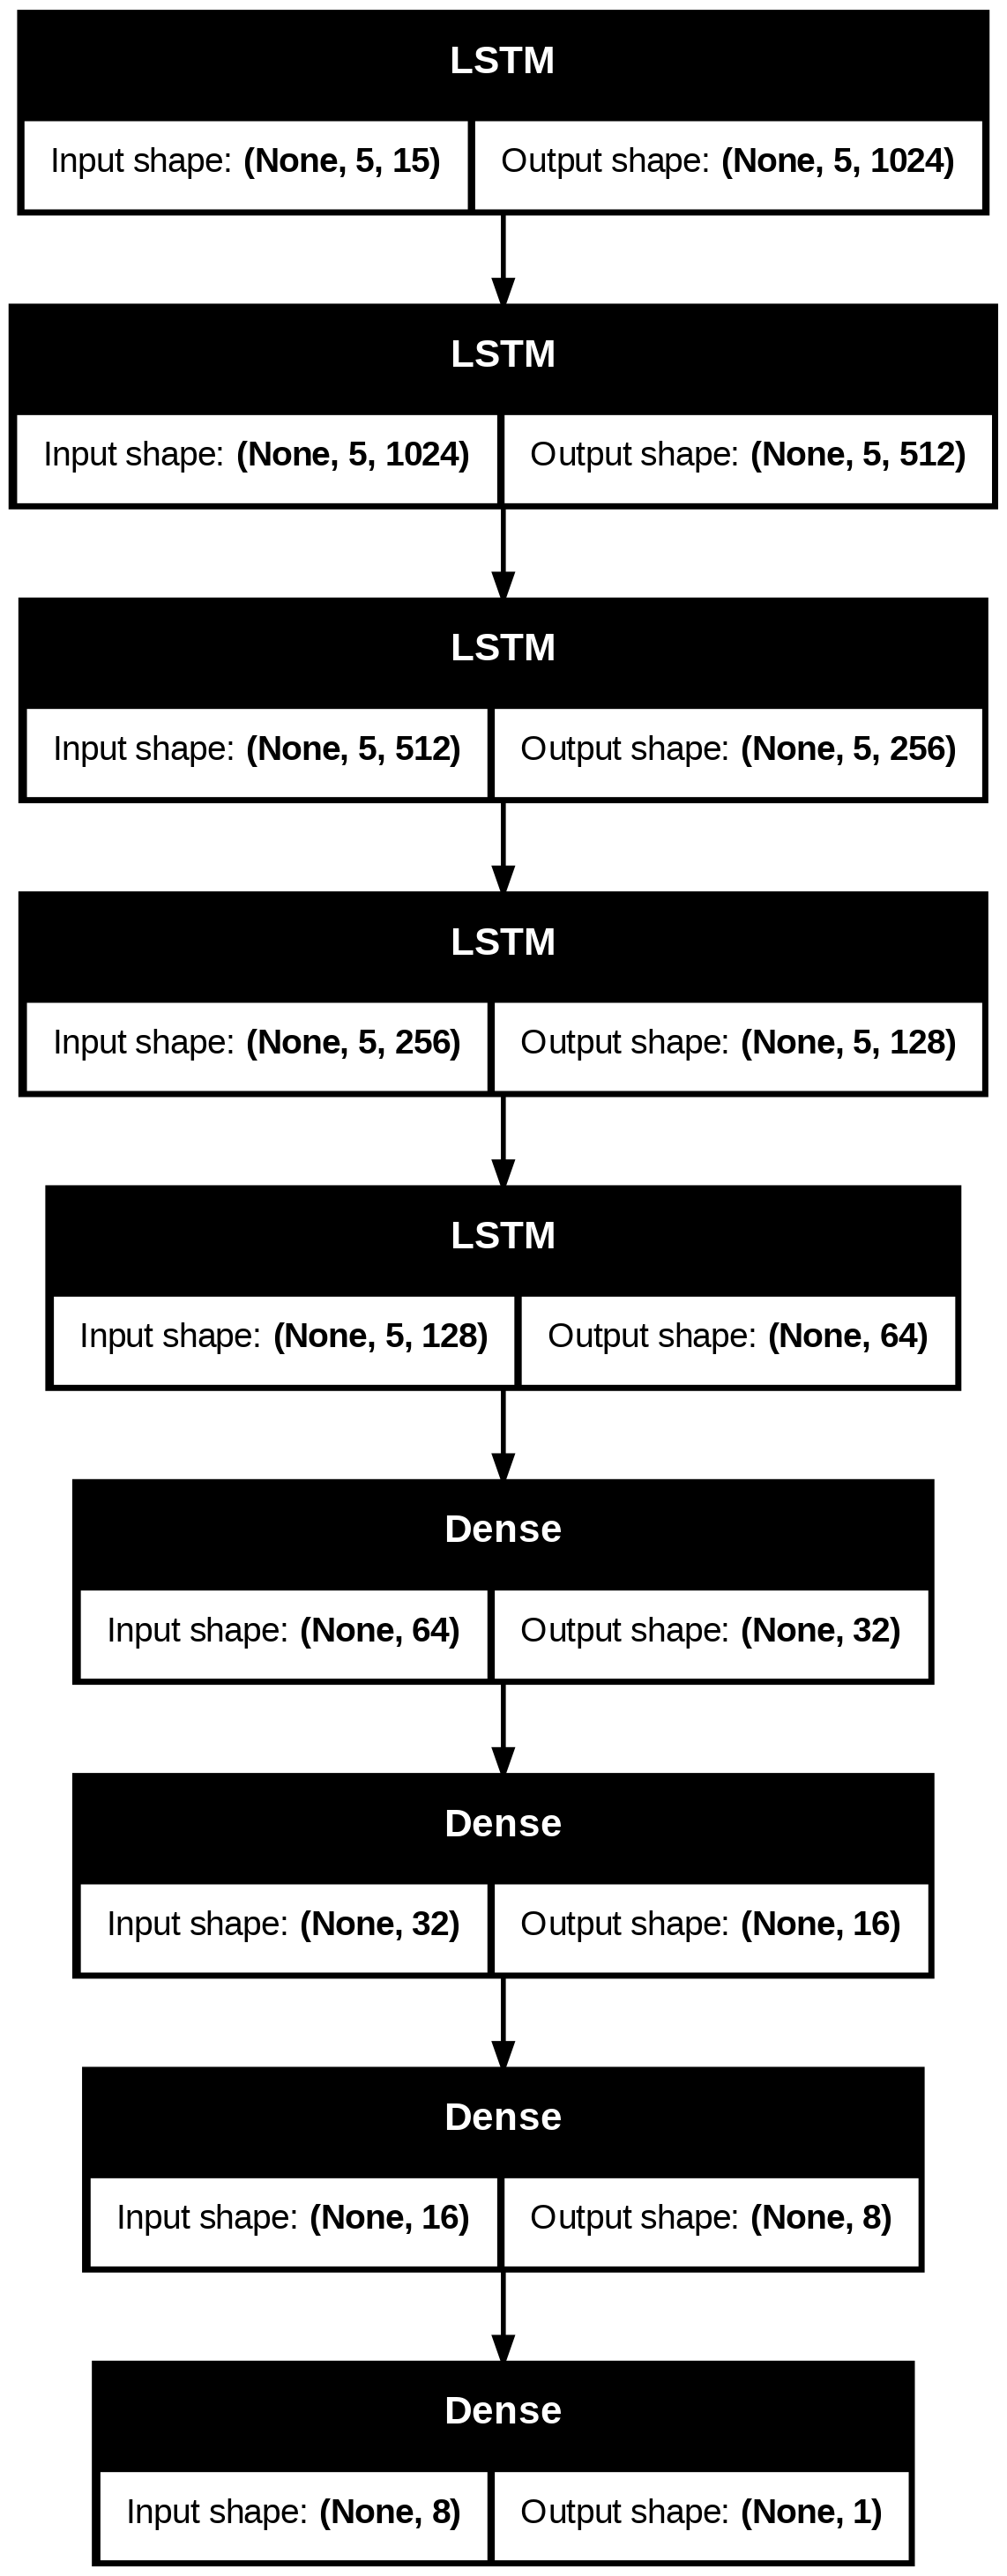

In [37]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

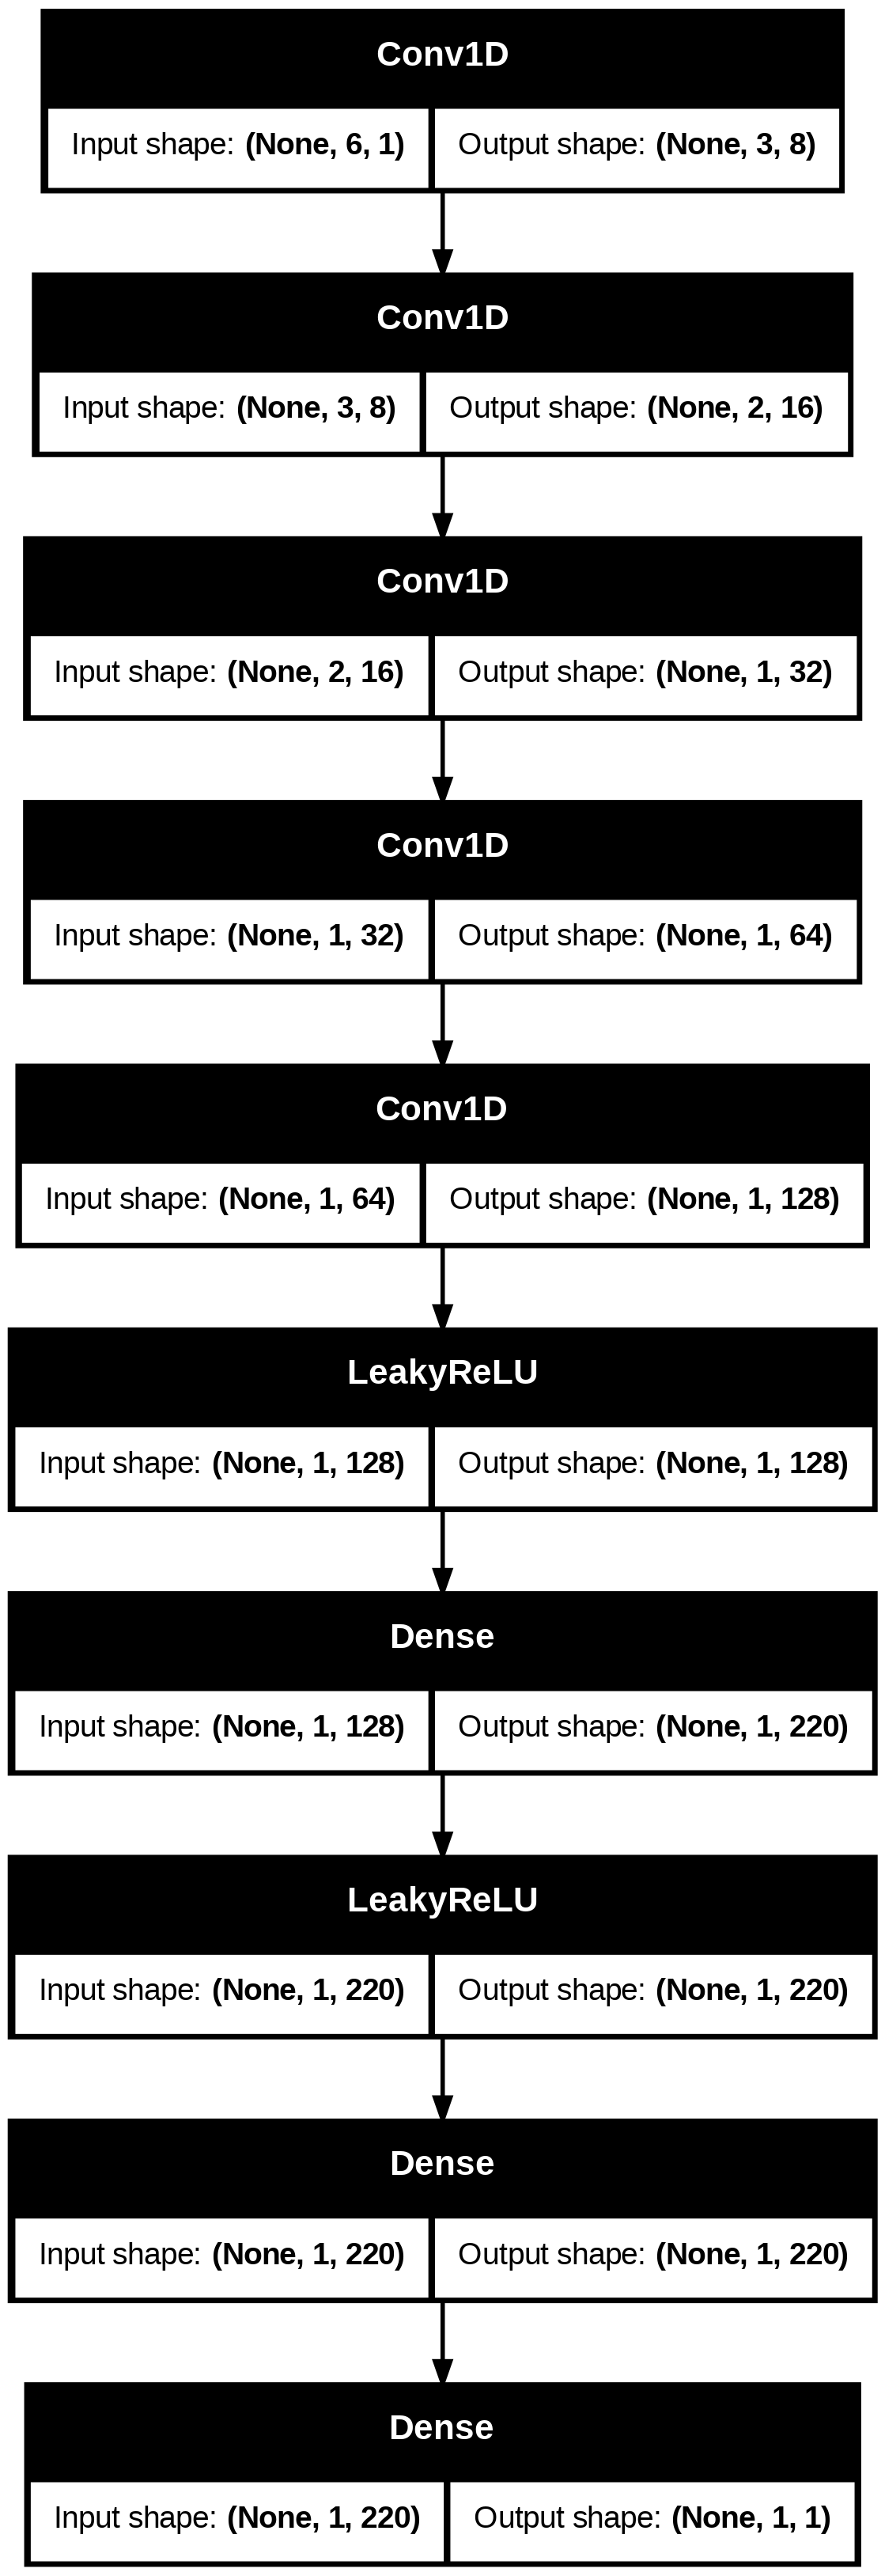

In [38]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

# **Train and test model**

 10%|█         | 51/500 [00:29<00:42, 10.59it/s]

epoch 50 discriminator_loss 1.3847407 generator_loss 0.69354206


 20%|██        | 101/500 [00:33<00:35, 11.14it/s]

epoch 100 discriminator_loss 1.3849218 generator_loss 0.7019669


 30%|███       | 152/500 [00:38<00:34, 10.21it/s]

epoch 150 discriminator_loss 1.3902996 generator_loss 0.6793948


 40%|████      | 202/500 [00:41<00:25, 11.50it/s]

epoch 200 discriminator_loss 1.3861814 generator_loss 0.70312


 50%|█████     | 252/500 [00:45<00:21, 11.51it/s]

epoch 250 discriminator_loss 1.3847377 generator_loss 0.6995796


 60%|██████    | 301/500 [00:50<00:19, 10.11it/s]

epoch 300 discriminator_loss 1.3873187 generator_loss 0.69270074


 70%|███████   | 351/500 [00:54<00:13, 11.27it/s]

epoch 350 discriminator_loss 1.3861011 generator_loss 0.69626373


 80%|████████  | 401/500 [00:57<00:08, 11.19it/s]

epoch 400 discriminator_loss 1.3863064 generator_loss 0.69223875


 90%|█████████ | 452/500 [01:02<00:04, 11.44it/s]

epoch 450 discriminator_loss 1.3862624 generator_loss 0.69165754


100%|██████████| 500/500 [01:06<00:00,  7.57it/s]


epoch 500 discriminator_loss 1.3873248 generator_loss 0.6878568


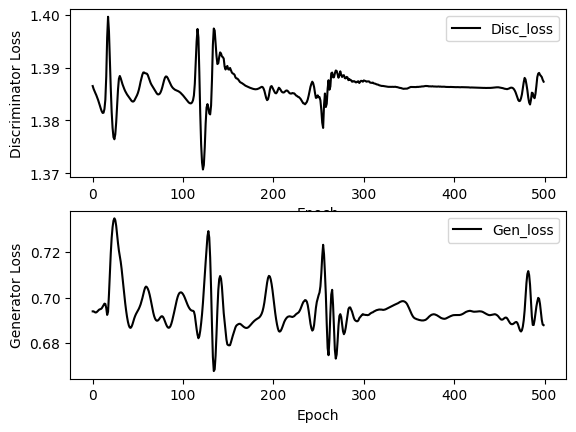

In [39]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [40]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  4.674453667139413


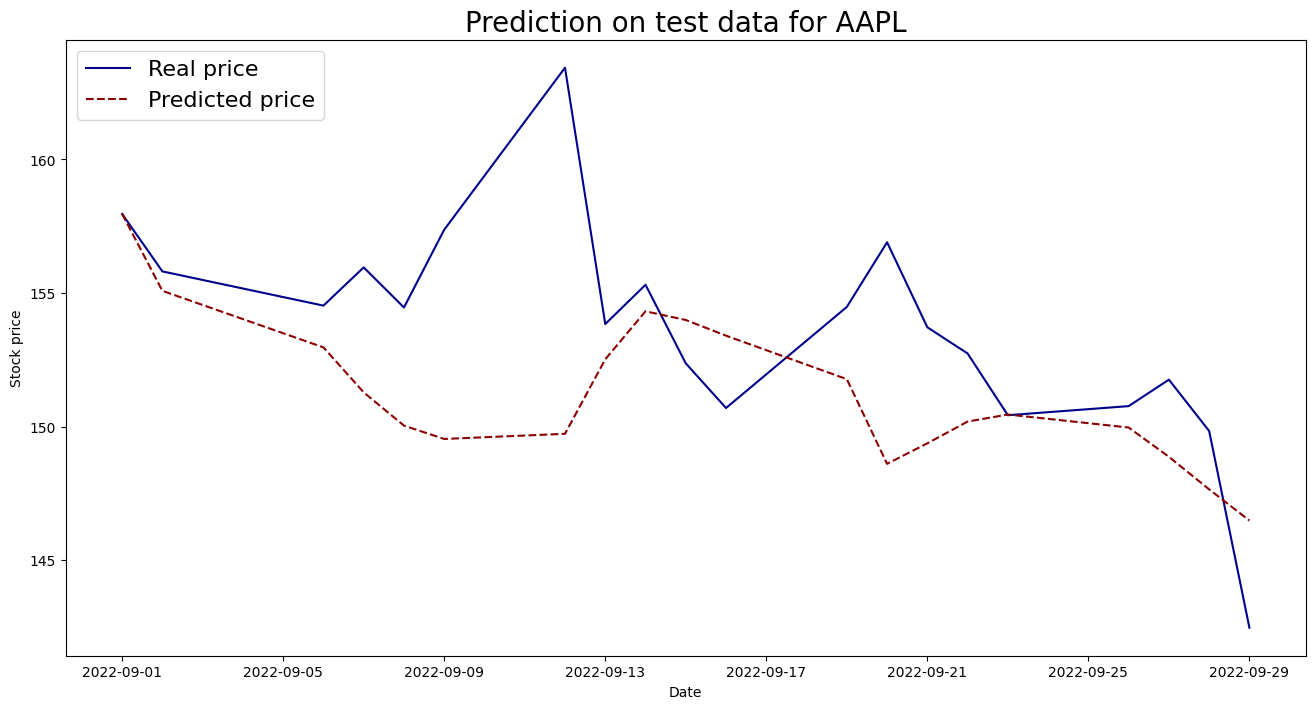

In [41]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)